# LinkScribe

## Data Exploration

In [1]:
## Initial libreries for data exploration 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 

In [2]:
# Reading the file and asigning the data to a varable 
Data = pd.read_csv("archive/website_classification.csv", index_col = 0)

In [3]:
# Initial Matrix
print(Data.shape)

(1408, 3)


In [4]:
# types of data 
print(Data.dtypes)

website_url             object
cleaned_website_text    object
Category                object
dtype: object


In [5]:
Data.head()

,website_url,cleaned_website_text,Category
0,https://www.booking.com/index.html?aid=1743217,official site good hotel accommodation big sav...,Travel
1,https://travelsites.com/expedia/,expedia hotel book sites like use vacation wor...,Travel
2,https://travelsites.com/tripadvisor/,tripadvisor hotel book sites like previously d...,Travel
3,https://www.momondo.in/?ispredir=true,cheap flights search compare flights momondo f...,Travel
4,https://www.ebookers.com/?AFFCID=EBOOKERS-UK.n...,bot create free account create free account si...,Travel


In [6]:
len(Data.Category.value_counts().index)

16

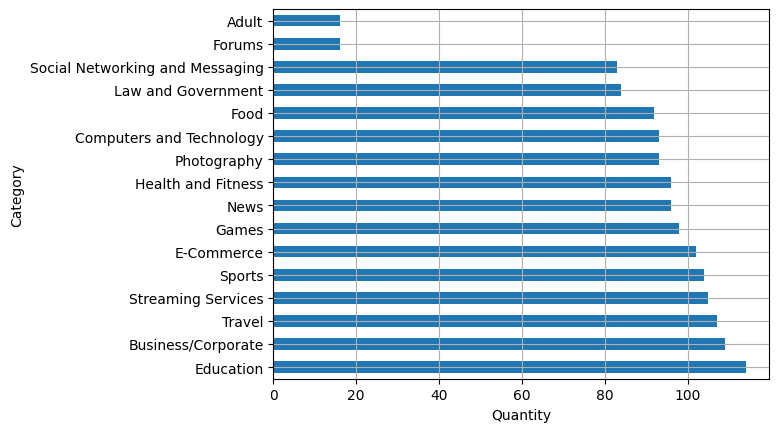

In [7]:
# Distribution among the different categories
Data.Category.value_counts().plot.barh()
plt.xlabel('Quantity')
plt.grid('ON')
plt.show()

In [8]:
Data.website_url.count()

1408

In [9]:
Data.website_url.apply(lambda x : 1 if x.startswith('https://') or x.startswith('http://') else 0).value_counts() 

website_url
1    1408
Name: count, dtype: int64

In [10]:

# Separating the URL from it's extention and creating a new column
Data['website_url_domain_and_extension'] = Data.website_url.apply(lambda x : x.split('/')[2])
Data['website_url_domain_and_extension']

0              www.booking.com
1              travelsites.com
2              travelsites.com
3               www.momondo.in
4             www.ebookers.com
                 ...          
1403          www.oldwomen.org
1404       www.webcamslave.com
1405       www.buyeuroporn.com
1406    www.analdreamhouse.com
1407    www.world-sex-news.com
Name: website_url_domain_and_extension, Length: 1408, dtype: object

In [11]:
Data.head()

,website_url,cleaned_website_text,Category,website_url_domain_and_extension
0,https://www.booking.com/index.html?aid=1743217,official site good hotel accommodation big sav...,Travel,www.booking.com
1,https://travelsites.com/expedia/,expedia hotel book sites like use vacation wor...,Travel,travelsites.com
2,https://travelsites.com/tripadvisor/,tripadvisor hotel book sites like previously d...,Travel,travelsites.com
3,https://www.momondo.in/?ispredir=true,cheap flights search compare flights momondo f...,Travel,www.momondo.in
4,https://www.ebookers.com/?AFFCID=EBOOKERS-UK.n...,bot create free account create free account si...,Travel,www.ebookers.com


## Sklearn Model 

Based on literature we are going to use this section to compare 4 of the most used classifiers. 

- Support Vector Machine
- Decision Tree Classifier
- Random Forest Classifier
- AdaBoostClassifier
- XGboost


This clarifiers are going to be implemented using a Pipeline that is going to help the usage of TfidfVectorizer as a feature extraction transformer tool 

### Libreries and training methods 

In [67]:
# Global imports for all SKL models 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.calibration import CalibratedClassifierCV

In [50]:
# Classifier Models
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb


import pickle
from pathlib import Path
import joblib

Methods that is goint to contain the model in the pipeLine, show the metrics and seve the model according to the analysis. 

In [141]:
"""
Project     :   Linkscribe
Package     :   ML-DL Model 
Method      :   pipeLineClassf
Author      :   jdmunoz

Description :   This method will train and get scores from different ML 
                classifiers using a pipeline where the TfidfVectorizer() 
                is a constant for the training as it will only be used for NLP. 

Inputs      :   X_train, X_test, 
                y_train, y_test,
                clf_name, clf_model,    --> Name of the classifier ex - classifiers = {'SVM': SVC()}
                metric= None            --> Type of avg of the scores precision, recall and f1 by default None

Modification History: 
*********************************************************
Date            Author          Modification
18-03-2024      jdmunoz         Creation
*********************************************************
"""
def pipeLineClassf( X_train, X_test, 
                    y_train, y_test,  
                    clf_name, clf_model, 
                    metric= None):

    #Pipe line for each Classifier
    pipeline = Pipeline([
        ('Tfidf', TfidfVectorizer()),
        (clf_name, clf_model)
    ])

    #Train and evaluate the model 
    pipeline.fit(X_train, y_train)      
    predictions = pipeline.predict(X_test)

    # Obtaining the scores 
    accuracy = accuracy_score(y_test, predictions)
    precision, recall,f1,_ = precision_recall_fscore_support(y_test, predictions, average=metric)
    
    # Result dictionary
    result = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }   

    return result, pipeline

"""
Project     :   Linkscribe
Package     :   ML-DL Model 
Method      :   saveBestModel   
Author      :   jdmunoz

Description :   This method saves the best ML model according to the chose metric

Inputs      :   models              --> Dictionary with the models name and metrics result 
                metric='accuracy'   --> Metric that is going to evaluate the best one to be saved,
                                        by default the metric is going to be 'accuracy'

Modification History: 
*********************************************************
Date            Author          Modification
18-03-2024      jdmunoz         Creation
*********************************************************
"""
def saveBestModel(models, pipelines, metric='accuracy'):

    # Creating the saving directory 
    MODELS_DIR = Path("models/")
    SKLEARN_MODEL_PATH = MODELS_DIR.joinpath("sklearn/Linkscribe.pk")
    SKLEARN_MODEL_PATH.parent.mkdir(exist_ok=True, parents=True)    
    
    best_metric_value = None
    best_model = None

    # Getting the best model according to input metric
    for model_clf, model_result in models.items():
        metric_value = model_result[metric]
        if best_metric_value is None or metric_value > best_metric_value:
            best_metric_value = metric_value
            best_model = pipelines[model_clf]

    # Saving the model to disk
    pickle.dump(
        best_model, open(SKLEARN_MODEL_PATH, "wb")
    )  # export the model to a file so we can use it later
      


Defining X and Y variables from the dataset

In [189]:
# x and Y variables for split 
X = Data.cleaned_website_text
Y = Data.Category

In [175]:
# output encoding
le = LabelEncoder()
Y = le.fit_transform(Y)

In [134]:
# splitting the Dataset in train and test
RANDOM_SEED = 42
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = RANDOM_SEED) 

In [135]:
# Classifiers dictionary 
classifiers = {
    'SVM_linear': SVC(kernel='linear')
    ,'SVM_RBF': SVC(kernel='rbf')
    ,'SVM_poly':SVC(kernel='poly', degree=3)
    ,'Decision Tree': DecisionTreeClassifier( random_state=1)
    ,'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)   
    ,'AdaBoostClassifier': AdaBoostClassifier(estimator= DecisionTreeClassifier(random_state=1),
                                            n_estimators    =   500,
                                            learning_rate   =   0.1,
                                            random_state    =   1)
    ,'xgboost': xgb.XGBClassifier()
}

In [140]:
# Results dictionary to be saved 
results = {}
pipelines = {}

for clf_name, clf in classifiers.items():
    result, pipeline = (pipeLineClassf(X_train, X_test, y_train, y_test, clf_name, clf, metric='weighted'))
    results[clf_name] = result
    pipelines[clf_name] = pipeline

# Display the results
for clf_name, metrics in results.items():
    print(f"Model: {clf_name}")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    print("\n")

/home/jdmunoz/Documents/Especia_AI/semestre_2/Proyectos/LinkScribe/Model/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jdmunoz/Documents/Especia_AI/semestre_2/Proyectos/LinkScribe/Model/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jdmunoz/Documents/Especia_AI/semestre_2/Proyectos/LinkScribe/Model/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels w

Model: SVM_linear
Accuracy: 0.9078
Precision: 0.9127
Recall: 0.9078
F1 Score: 0.9053


Model: SVM_RBF
Accuracy: 0.8818
Precision: 0.9050
Recall: 0.8818
F1 Score: 0.8823


Model: SVM_poly
Accuracy: 0.3877
Precision: 0.9096
Recall: 0.3877
F1 Score: 0.4783


Model: Decision Tree
Accuracy: 0.6028
Precision: 0.6054
Recall: 0.6028
F1 Score: 0.5990


Model: Random Forest
Accuracy: 0.8345
Precision: 0.8263
Recall: 0.8345
F1 Score: 0.8270


Model: AdaBoostClassifier
Accuracy: 0.6005
Precision: 0.6206
Recall: 0.6005
F1 Score: 0.6029


Model: xgboost
Accuracy: 0.8014
Precision: 0.8057
Recall: 0.8014
F1 Score: 0.7982




In [142]:
#save the best model according to the most important metric
saveBestModel(results, pipelines, metric='Accuracy')

### Saved Model test 

In [148]:
# Loading the model 
loaded_model = pickle.load(open('models/sklearn/Linkscribe.pk', 'rb'))

predictions = loaded_model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(accuracy)

0.9078014184397163


In [150]:
# Web scraping, pickle imports
import requests
from bs4 import BeautifulSoup
import pickle
from time import sleep

In [215]:
"""
Project     :   Linkscribe
Package     :   ML-DL Model 
Method      :   get_text_from_webpage   
Author      :   jdmunoz

Description :   This method gets the pure text from webpages

Inputs      :   url --> URL from webscraping

Modification History: 
*********************************************************
Date            Author          Modification
25-03-2024      jdmunoz         Creation
*********************************************************
"""
def get_text_from_webpage(url):
    # Send a GET request to the URL
    response = requests.get(url)
    
    # Check if the request was successful
    if response.status_code == 200:
        # Parse the HTML content of the page using BeautifulSoup
        soup = BeautifulSoup(response.content, 'html.parser')
        
        # Extract text from the parsed HTML
        text = soup.get_text(separator='\n', strip=True)
        
        return text
    else:
        # If the request was not successful, print an error message
        print(f"Error: Unable to retrieve content from {url}. Status code: {response.status_code}")
        return None

# Example usage:
# url = "https://m.allfootballapp.com/news/Headline/Spain---Brazil-times-how-to-watch-on-TV-stream-online-%7C-International-Friendly/3334668"
url = "https://www.taste.com.au/quick-easy/galleries/top-100-easy-dinner-recipes/biccuul7"
webpage_text = get_text_from_webpage(url)

text = [webpage_text]
if webpage_text:
    print(webpage_text)

Top 100 easy dinner recipes
Log In
|
Sign Up
Recipes
Dinner
Quick & Easy
Healthy
Baking
Entertaining
Test Kitchen
Food News
The Savvy Dinner Plan
Video
Win!
More
The Savvy Dinner Plan
Video
Win!
Top 100 easy dinner recipes
When you need to feed the family or kids, these are the easy dinner recipes you turn to time and time again. With lots of healthy, quick, vegetarian, chicken, and budget-friendly ideas, there’s something for everyone..
1
Australia's favourite zucchini slice recipe (with video)
Our most-loved zucchini slice recipe ever
While the argument as to what is Australia’s national dish will always rage (is it roast lamb, green chicken curry or a barramundi burger)? One thing is for sure, zucchini slice is hands-down the national food of the home cook.
Your lamb, barra and curry may turn up on the menu of a restaurant, but our favourite savoury slice never will. It’s too humble. It just moseys its way into lunch boxes, dinners and even canapes. There’s a reason zucchini slice i

In [204]:

Categories = np.array(['Adult', 'Business/Corporate', 'Computers and Technology',
       'E-Commerce', 'Education', 'Food', 'Forums', 'Games',
       'Health and Fitness', 'Law and Government', 'News', 'Photography',
       'Social Networking and Messaging', 'Sports', 'Streaming Services',
       'Travel'], dtype=object)

test = LabelEncoder()
ya_t = test.fit_transform(Categories)
print(ya_t,Categories)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] ['Adult' 'Business/Corporate' 'Computers and Technology' 'E-Commerce'
 'Education' 'Food' 'Forums' 'Games' 'Health and Fitness'
 'Law and Government' 'News' 'Photography'
 'Social Networking and Messaging' 'Sports' 'Streaming Services' 'Travel']


In [216]:
predictions = loaded_model.predict(text)

p = test.inverse_transform(predictions)
print(p)

['Food']


# DL model 

Based on the literature we are going to use different configurations and techniques of deep learning, explaining the different configurations. We are going to show five experiments: 




In [35]:
import random
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import layers

In [22]:
# x and Y variables for split 
X = Data.cleaned_website_text
Y = Data.Category

In [23]:
# output encoding
Y = LabelEncoder().fit_transform(Y)

In [24]:
# splitting the Dataset in train and test
RANDOM_SEED = 43
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = RANDOM_SEED)

In [32]:
# Find average number of words in dataset

lengths_of_description = [len(sentence.split()) for sentence in X_train.values]
np.mean(lengths_of_description)
np.percentile(lengths_of_description, 90)

1678.6

In [27]:
"""
from tensorflow.keras.layers import TextVectorization:

A preprocessing layer which maps text features to integer sequences.
"""

output_sequence_length = 1679
text_vectorization = TextVectorization(output_mode = 'int', 
                                       output_sequence_length = output_sequence_length)

2024-03-25 10:21:46.844447: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-25 10:21:46.844527: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-25 10:21:46.969382: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-25 10:21:47.213627: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-25 10:21:49.347215: W tensorflow/compiler/tf2

In [29]:
text_vectorization.adapt(X_train.values)

# take a random sample and tokenize it
random_s = random.choice(X_train.values)
print(f"original : {random_s.split()[:20]}", "\n",text_vectorization([random_s]).numpy()[0][:20])

original : ['free', 'webcam', 'chat', 'rooms', 'camamba', 'free', 'webcam', 'chat', 'community', 'find', 'new', 'friend', 'world', 'chat', 'flirt', 'play', 'share', 'camamba', 'chat', 'free'] 
 [   9 4380   32 1665 9777    9 4380   32  148   20    3  365    6   32
 6188   35   45 9777   32    9]


In [31]:
words = text_vectorization.get_vocabulary()
top5 = words[:5]
bottom5 = words[-5:]

print(f"Number of words in vocab : {len(words)}")
print(f"Top 5 : {top5}")
print(f"bottom 5 : {bottom5}")

Number of words in vocab : 47575
Top 5 : ['', '[UNK]', 'news', 'new', 'read']
bottom 5 : ['02001f', '02000f', '01st', '0084ff', '007f']


## Embeddings 

In [36]:
"""
Model's architecture with Embeddings 
"""
# Input Layer string
inputs = layers.Input(shape = (1, ), dtype = tf.string)
# Text vectorizer layer 
text_vectorizer = text_vectorization(inputs)
# Embedding layer
embed = layers.Embedding(output_dim = 128, 
                        input_dim = len(words),
                        input_length = 1679)(text_vectorizer)
# AVG pooling Layer 
x = layers.GlobalAveragePooling1D()(embed)
# Output 
outputs = layers.Dense(16, activation = 'softmax')(x)

model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 1679)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 1679, 128)         6089600   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 16)                2064      
                                                                 
Total params: 6091664 (23.24 MB)
Trainable params: 6091664 (2

In [37]:
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(), 
              optimizer = 'adam', 
              metrics = ['accuracy'])

In [38]:
h1 = model.fit(X_train, y_train, epochs = 20, validation_data = (X_test, y_test))

Epoch 1/20


2024-03-25 10:33:18.903842: I external/local_xla/xla/service/service.cc:168] XLA service 0x72ee702ebcc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-25 10:33:18.903879: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1050, Compute Capability 6.1
2024-03-25 10:33:18.930909: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-25 10:33:18.993992: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1711380799.151350    9962 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


31/31 [==============================] - 6s 153ms/step - loss: 2.7517 - accuracy: 0.1645 - val_loss: 2.7344 - val_accuracy: 0.1820
Epoch 2/20
31/31 [==============================] - 5s 147ms/step - loss: 2.7078 - accuracy: 0.2305 - val_loss: 2.7020 - val_accuracy: 0.1962
Epoch 3/20
31/31 [==============================] - 4s 142ms/step - loss: 2.6622 - accuracy: 0.2528 - val_loss: 2.6677 - val_accuracy: 0.2009
Epoch 4/20
31/31 [==============================] - 5s 147ms/step - loss: 2.6128 - accuracy: 0.2883 - val_loss: 2.6323 - val_accuracy: 0.2388
Epoch 5/20
31/31 [==============================] - 5s 147ms/step - loss: 2.5595 - accuracy: 0.3350 - val_loss: 2.5911 - val_accuracy: 0.2648
Epoch 6/20
31/31 [==============================] - 4s 139ms/step - loss: 2.4984 - accuracy: 0.3594 - val_loss: 2.5450 - val_accuracy: 0.2884
Epoch 7/20
31/31 [==============================] - 4s 131ms/step - loss: 2.4306 - accuracy: 0.4213 - val_loss: 2.4941 - val_accuracy: 0.3144
Epoch 8/20
31/31 

## Conv1D Model 

In [45]:

inputs = layers.Input(shape = (1, ), dtype = tf.string)
text_vectorizer = text_vectorization(inputs)
embed = layers.Embedding(output_dim = 128, 
                        input_dim = len(words),
                        input_length = 1660)(text_vecto rizer)
# Convolutional layer 
x1 = layers.Conv1D(64, kernel_size = 5, padding = "same")(embed)
xAGV1 = layers.GlobalAveragePooling1D()(x1)
outputs = layers.Dense(16, activation = 'softmax')(xAGV1)

model2 = tf.keras.Model(inputs, outputs)
model2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 1679)              0         
 ctorization)                                                    
                                                                 
 embedding_5 (Embedding)     (None, 1679, 128)         6089600   
                                                                 
 conv1d_6 (Conv1D)           (None, 1679, 64)          41024     
                                                                 
 global_average_pooling1d_5  (None, 64)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_3 (Dense)             (None, 16)                1040

In [40]:
model2.compile(loss = 'sparse_categorical_crossentropy', 
               optimizer = 'adam', 
               metrics = ['accuracy'])

In [41]:
h2 = model2.fit(X_train, y_train, epochs = 20, validation_data = (X_test, y_test))

Epoch 1/20
31/31 [==============================] - 8s 189ms/step - loss: 2.7422 - accuracy: 0.1127 - val_loss: 2.6991 - val_accuracy: 0.1324
Epoch 2/20
31/31 [==============================] - 5s 149ms/step - loss: 2.6441 - accuracy: 0.1645 - val_loss: 2.6188 - val_accuracy: 0.1489
Epoch 3/20
31/31 [==============================] - 4s 145ms/step - loss: 2.4814 - accuracy: 0.2650 - val_loss: 2.4547 - val_accuracy: 0.2246
Epoch 4/20
31/31 [==============================] - 5s 148ms/step - loss: 2.2471 - accuracy: 0.3746 - val_loss: 2.2441 - val_accuracy: 0.4019
Epoch 5/20
31/31 [==============================] - 4s 136ms/step - loss: 1.9479 - accuracy: 0.5574 - val_loss: 2.0049 - val_accuracy: 0.5035
Epoch 6/20
31/31 [==============================] - 5s 147ms/step - loss: 1.6336 - accuracy: 0.6853 - val_loss: 1.7755 - val_accuracy: 0.5603
Epoch 7/20
31/31 [==============================] - 5s 146ms/step - loss: 1.3478 - accuracy: 0.7584 - val_loss: 1.5910 - val_accuracy: 0.5887
Epoch 

## Dropout layer 

In [46]:

inputs = layers.Input(shape = (1, ), dtype = tf.string)
text_vectorizer = text_vectorization(inputs)
embed = layers.Embedding(output_dim = 128, 
                        input_dim = len(words),
                        input_length = 1660)(text_vectorizer)
x = layers.Conv1D(32, kernel_size = 5, padding = "same")(embed)
x = layers.GlobalMaxPooling1D()(x)
# Dropout layer 
x = layers.Dropout(0.7)(x)
outputs = layers.Dense(16, activation = 'softmax')(x)

model3 = tf.keras.Model(inputs, outputs)
model3.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 1679)              0         
 ctorization)                                                    
                                                                 
 embedding_6 (Embedding)     (None, 1679, 128)         6089600   
                                                                 
 conv1d_7 (Conv1D)           (None, 1679, 32)          20512     
                                                                 
 global_max_pooling1d (Glob  (None, 32)                0         
 alMaxPooling1D)                                                 
                                                                 
 dropout (Dropout)           (None, 32)                0   

In [47]:

model3.compile(loss = 'sparse_categorical_crossentropy', 
               optimizer = 'adam', 
               metrics = ['accuracy'])

In [48]:
h3 = model3.fit(X_train, y_train, epochs = 20, validation_data = (X_test, y_test))

Epoch 1/20
31/31 [==============================] - 9s 182ms/step - loss: 2.7656 - accuracy: 0.0741 - val_loss: 2.7390 - val_accuracy: 0.0851
Epoch 2/20
31/31 [==============================] - 5s 155ms/step - loss: 2.6684 - accuracy: 0.1279 - val_loss: 2.6968 - val_accuracy: 0.1560
Epoch 3/20
31/31 [==============================] - 5s 150ms/step - loss: 2.5553 - accuracy: 0.2030 - val_loss: 2.6412 - val_accuracy: 0.2246
Epoch 4/20
31/31 [==============================] - 4s 143ms/step - loss: 2.4494 - accuracy: 0.2487 - val_loss: 2.5757 - val_accuracy: 0.2766
Epoch 5/20
31/31 [==============================] - 5s 151ms/step - loss: 2.3080 - accuracy: 0.3046 - val_loss: 2.4906 - val_accuracy: 0.3901
Epoch 6/20
31/31 [==============================] - 5s 160ms/step - loss: 2.1846 - accuracy: 0.3431 - val_loss: 2.3861 - val_accuracy: 0.4704
Epoch 7/20
31/31 [==============================] - 5s 158ms/step - loss: 2.0637 - accuracy: 0.3716 - val_loss: 2.2972 - val_accuracy: 0.5437
Epoch 